In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor 

In [2]:
water = pd.read_csv("../site_snow.csv")
months = ["Jan","Feb","Mar"]
water["Snow Ratio"] = water[months].sum(axis=1).div(water["Apr"] + .001)


water_2 = pd.get_dummies(water, columns=['Site_Name', 'County'])
water_2.head()

y = water_2["Apr"] + .001
y = y.fillna(0.001)
X = water_2.drop(["Apr","Apr (WE)","May", "May (WE)", "Jun", "Jun (WE)"], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2, random_state=42)

### RANDOM FOREST REGRESSOR


In [307]:
# Define preprocessing steps for numeric and categorical features
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('rounder', FunctionTransformer(np.round, validate=False)),  # Round numeric features
    ('scaler', StandardScaler())
])

categorical_features = X.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create a Random Forest Regressor pipeline
rf_regressor = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', RandomForestRegressor(max_depth=20, n_estimators=100))])

# Train the model
rf_regressor.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('rounder',
                                                                   FunctionTransformer(func=<function round at 0x000001EFD9611BB0>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Elev', 'Lat', 'Lon', 'installed', 'Water Year', 'Jan', 'Jan (WE)',
       'Feb', 'Feb (WE)', 'Mar', 'Mar (WE)', 'Snow Ratio'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index([], dtype='object'))])),
                ('regressor', RandomForestRegressor(max_depth=20))])

In [321]:
rf_y_pred = rf_regressor.predict(X_test)
print("Random Forest Regressor R2 Score:",r2_score(y_test, rf_y_pred))
print("Random Forest Regressor MAE :",mean_absolute_error(y_pred=rf_y_pred,y_true=y_test))
print("Random Forest Regressor MSE:",mean_squared_error(y_pred=rf_y_pred,y_true=y_test))
print("Random Forest Regressor MSE:",np.sqrt(mean_squared_error(y_pred=rf_y_pred,y_true=y_test)))

Random Forest Regressor R2 Score: 0.965335164026282
Random Forest Regressor MAE : 3.723336668067641
Random Forest Regressor MSE: 29.001926576290874
Random Forest Regressor MSE: 5.38534368228165


In [309]:
feature_importance = rf_regressor.named_steps['regressor'].feature_importances_
sorted_idx = feature_importance.argsort()[::-1]
sorted_idx


array([10, 11,  9,  7,  4,  5,  8,  0,  6,  2,  3,  1], dtype=int64)

In [310]:
for index in sorted_idx:
    print(water.iloc[:, index].name)


Feb (WE)
Mar
Feb
Jan
installed
County
Jan (WE)
Site_Name
Water Year
Lat
Lon
Elev


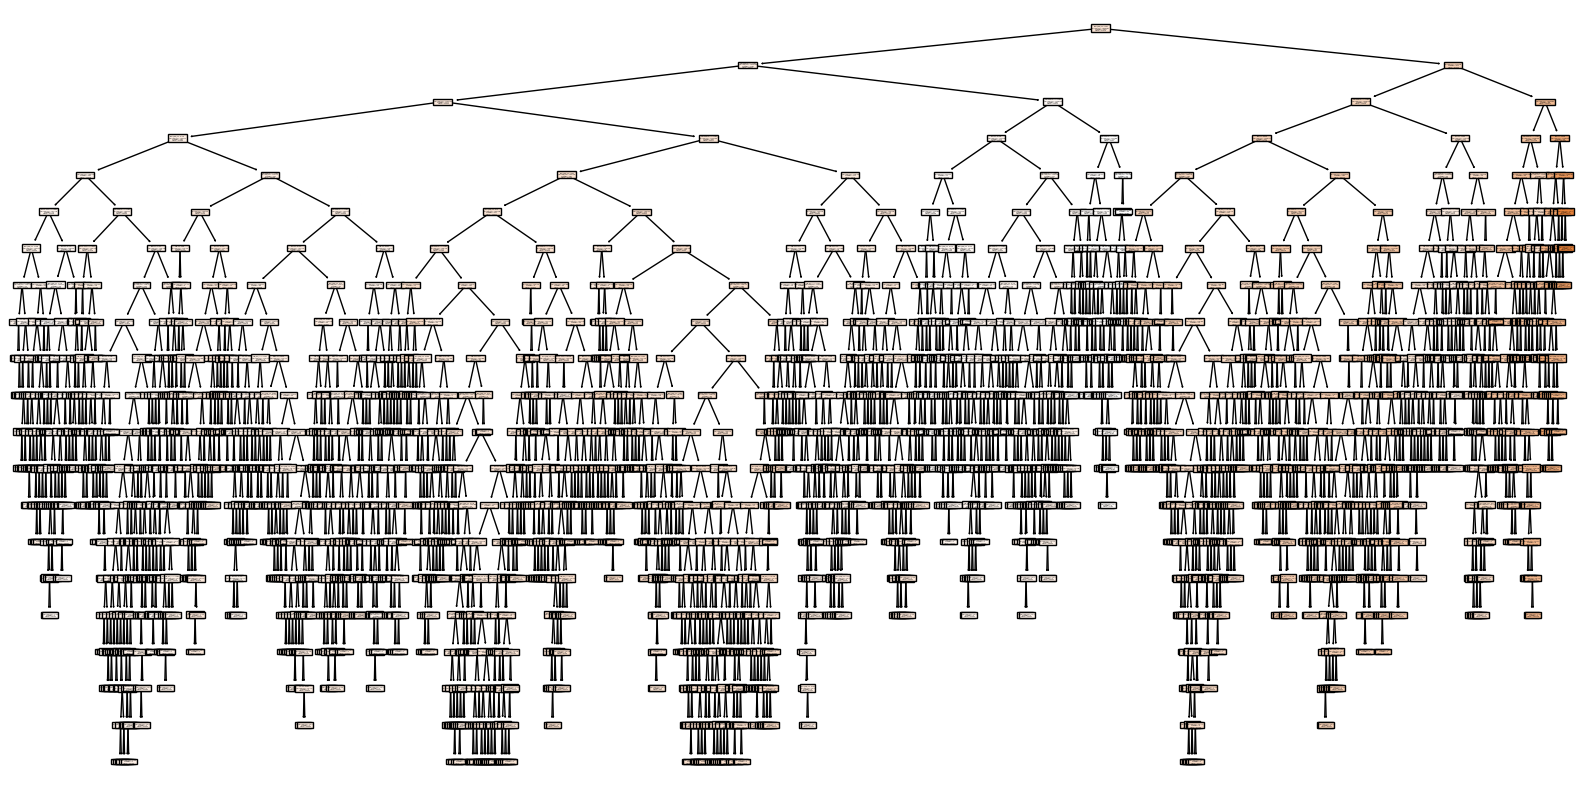

In [314]:
import sklearn.tree as tree

tree_to_visualize = rf_regressor.named_steps['regressor'].estimators_[0]

# Visualize the tree
plt.figure(figsize=(20, 10))
tree.plot_tree(tree_to_visualize, filled=True, feature_names=numeric_features.tolist() + categorical_features.tolist())
plt.show()

### LASSO REGRESSION

In [297]:
## Lasso Model

# X['Water Year'] = X['Water Year'].astype(object)
# X['installed'] = X['installed'].astype(object)

numeric_cols = X.select_dtypes(include=['float64']).columns
X[numeric_cols] = X[numeric_cols].round(4)

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

lasso = Pipeline(steps=[('preprocessor', preprocessor),
                         ('regressor', Lasso(alpha=.01))])

In [298]:
fitted_model = lasso.fit(X_train,y_train)

In [320]:
lasso_y_pred = fitted_model.predict(X_test)

print("Lasso R2 :",r2_score(y_test, lasso_y_pred))
print("Lasso MAE :",mean_absolute_error(y_pred=lasso_y_pred,y_true=y_test))
print("Lasso MSE:",mean_squared_error(y_pred=lasso_y_pred,y_true=y_test))
print(f'Lasso RMSE : {np.sqrt(mean_squared_error(y_pred=lasso_y_pred,y_true=y_test))}')


Lasso R2 : 0.21280209730690713
Lasso MAE : 16.63923362671523
Lasso MSE: 658.5998500677924
Lasso RMSE : 25.663200308375266


In [303]:
names =fitted_model.named_steps['regressor']

names.coef_

sorted_idx = np.argsort(feature_importance)[::-1]

# Get the names of the most important features
feature_names = X_train.columns
most_important_features = feature_names[sorted_idx]

print("Most important features:")
for i in range(10):  # Print the top 10 most important features
    print(f"{i+1}. {most_important_features[i]}")

Most important features:
1. Mar (WE)
2. Snow Ratio
3. Mar
4. Feb
5. Water Year
6. Jan
7. Feb (WE)
8. Elev
9. Jan (WE)
10. Lon


### SUPPORT VECTOR REGRESSOR

In [319]:
from sklearn.svm import SVR

numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = X.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

svm_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', SVR(kernel='linear', C=4))])

svm_pipeline.fit(X_train, y_train)

svm_y_pred = svm_pipeline.predict(X_test)

mse = mean_squared_error(y_test, svm_y_pred)
r2 = r2_score(y_test, svm_y_pred)
mae = mean_absolute_error(y_test,svm_y_pred)

print(f'SVM Mean Squared Error: {mse}')
print(f'SVM R-squared: {r2}')
print(f'SVM MAE:  {mae}')
print(f'SVM RMSE : {np.sqrt(mse)}')


SVM Mean Squared Error: 128.44276718971025
SVM R-squared: 0.8464775281418156
SVM MAE:  8.173421468166687
SVM RMSE : 11.333259336559376


### KNN REGRESSOR

In [318]:
from sklearn.neighbors import KNeighborsRegressor

numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = X.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Add the KNN regressor to the pipeline
knn_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('regressor', KNeighborsRegressor(n_neighbors=7))])

# Train the model
knn_pipeline.fit(X_train, y_train)

# Make predictions
knn_y_pred = knn_pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, knn_y_pred)
r2 = r2_score(y_test, knn_y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')
print(f'RMSE : {np.sqrt(mse)}')

Mean Squared Error: 120.28414073036227
R-squared: 0.8562292060946637
RMSE : 10.967412672566045
